In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
import os, sagemaker, subprocess, boto3
from datetime import datetime
from sagemaker import s3
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.deserializers import JSONDeserializer

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
default_bucket = sess.default_bucket()
region = sess.boto_session.region_name

In [ ]:
# TODO
# 1/ Upload model params <best.pt> & test file <3-produce.jpg>
# 2/ Modify model name in inference.py if need

In [ ]:
!cp best.pt yolov5
!cp inference.py yolov5
!cp -r yolov5 code
!tar -cpzf model.tar.gz code/
!rm -rf code

In [ ]:
YOUR_PATH = 'yolov5-test-deploy'
_BASE_PATH = sagemaker.utils.name_from_base(YOUR_PATH)
s3_code_artifact = sess.upload_data(f"model.tar.gz",
                                    default_bucket,
                                    _BASE_PATH)

model = PyTorchModel(entry_point='inference.py',
                     model_data=s3_code_artifact, 
                     framework_version='1.12',
                     py_version='py38',
                     role=role,
                     # env={'TS_MAX_RESPONSE_SIZE':'20000000', 'YOLOV8_MODEL': model_name},
                     sagemaker_session=sess)

In [ ]:
# INSTANCE_TYPE = 'ml.m5.4xlarge'
INSTANCE_TYPE = 'ml.g4dn.2xlarge'
ENDPOINT_NAME = 'EDP-'+_BASE_PATH

predictor = model.deploy(initial_instance_count=1,
                         instance_type=INSTANCE_TYPE,
                         deserializer=JSONDeserializer(),
                         endpoint_name=ENDPOINT_NAME)

## Inference

In [ ]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
import pandas as pd
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

In [ ]:
# use above variable or copy from console
# ENDPOINT_NAME = 'EDP-yolov5-test-deploy-2023-06-21-15-33-34-409'

In [ ]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

In [ ]:
def draw_label (image, box, conf, label, imgHeight):
    bbox = np.array(box).astype(np.int32)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), [0,0,255], 2, cv2.LINE_AA)
    cv2.putText(image, "{}:{}".format(label,str(conf)[0:4]), (bbox[0], bbox[1] - 10),  0, 5e-4 * imgHeight, [0,0,255], 2)

def plot_image(img):
    dpi = 80
    figsize = imgWidth / float(dpi), imgHeight / float(dpi)    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
img_path = '3-produce.jpg'
payload = open(img_path, 'rb').read()
# pr = json.loads(predictor.predict(data))
pr = predictor.predict(payload)
df = pd.DataFrame(data=pr["data"], index = pr["index"], columns = pr["columns"])
df

In [ ]:
img = cv2.imread(img_path)
imgHeight,imgWidth,_ = img.shape
imgHeight,imgWidth,_

for index, row in df.iterrows():
    bboxes = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
    draw_label(img, bboxes,row["confidence"],row['name'],imgHeight)

plot_image(img)

## Performance

In [ ]:
%%timeit -n3 -r1
predictor.predict(payload)

#### g4dn.2xl
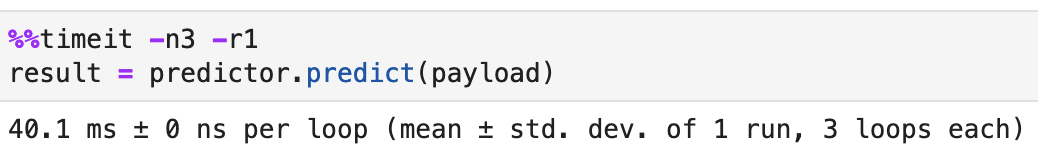
#### m5.4xl
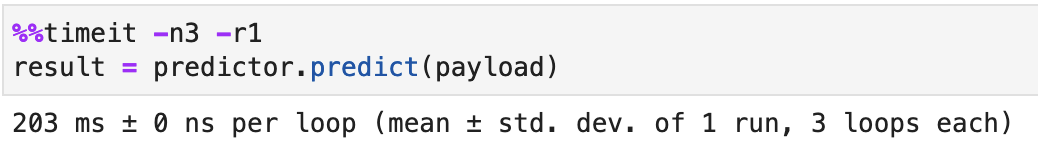